In [36]:
import pipelines_classes as our_ppl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import json
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn.model_selection import cross_validate
import category_encoders as ce
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
other_train = pd.read_csv('31/other_train.csv')
other_valid = pd.read_csv('31/other_valid.csv')

personal_train = pd.read_csv('31/personal_train.csv')
personal_valid = pd.read_csv('31/personal_valid.csv')

In [3]:
result_train = our_ppl.merge_and_deduplicate(personal_train, other_train, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [49]:
result_valid = our_ppl.merge_and_deduplicate(personal_valid, other_valid, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [51]:
other_valid.shape

(1022, 34)

In [52]:
personal_valid.shape

(972, 6)

In [50]:
result_valid.shape

(972, 38)

In [4]:
result_train.shape

(2237, 38)

In [53]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'FTI','age']

all_numeric_columns = ['FTI', 'T3', 'T4U',  'TSH', 'TT4', 'age', 'capital-gain',
                       'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']

categorical_columns = ['occupation','sex','workclass', 'tumor']

all_categorical_columns = ['marital-status','education','native-country','occupation',
                       'race','referral source','relationship','sex','sick','tumor','workclass',
                       'pregnant',	'thyroid surgery', 'I131 treatment',  'psych', 'query hypothyroid']


encoder = ce.OneHotEncoder()
model_numeric = LinearRegression()
model_categorical = RandomForestClassifier(n_estimators = 100,
                    max_depth = 12, random_state = 8)


ppl = Pipeline([
    
    ('ExtraxtMedicalInfo',our_ppl.Extraction('medical_info')),
    ('AllNumObjectstoNumeric', our_ppl.ObjectToNumeric(all_numeric_columns)),
    
    
    ('ReplaceFalseCorrect',our_ppl.StringReplacer(true_false_cols,'f','f')),
    ('ReplaceTrueCorrect',our_ppl.StringReplacer(true_false_cols,'t','t')),
    
    ('ReplaceClassNegative',our_ppl.StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',our_ppl.StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',our_ppl.StringReplacer(['class'],'decrease','decreased')),
    
    ('FindNans', our_ppl.StringReplacer(all_categorical_columns, '?', np.NaN)),
    
    # normalizacia
    ('Ln', our_ppl.LogNormalization(numeric_columns)),
    # odstranenie outlierov
    ('ReplaceExtremes',our_ppl.ReplaceOutliersWithPercentile(numeric_columns)),
    # doplnenie prazdnych hodnot modelmi
    ('ReplaceNumericNansWithModel',our_ppl.ReplaceNanWithModel(numeric_columns, LinearRegression(), numeric_columns)),
    ('ReplaceCategoricalNansWithModel', our_ppl.ReplaceCategoryNanWithModel(['occupation','sex','workclass','tumor'],
                                                               ['occupation','sex','workclass', 'tumor', 'marital-status'],
                                                                model_categorical, encoder)),
    # doplnenie prazdnych hodnot v pripade velkeho poctu kategorii, ktore predpokladame, ze z pohladu analyzy nezohravaju az taku dolezitu ulohu
    ('ReplaceWithMostFrequent', our_ppl.ReplaceMostFrequent(col_names=['native-country','FTI measured', 'relationship',
                                                               'query hypothyroid','hours-per-week']))
    
#     ("SelectColumns",our_ppl.Selector(columns = []))
    
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)
X_valid = ppl.transform(result_valid)

-- Extraction of  medical_info
-- Transform object to numeric for:  ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age', 'capital-gain', 'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']
-- Replacing: ** f ** to:  f  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** t ** to:  t  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** negativ ** to:  negative  , for:  ['class']
-- Replacing: ** increase ** to:  incr

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


pocet hodnot: 2000/2237, workclass(accuracy score): 0.749998054226
pocet hodnot: 2000/2237, tumor(accuracy score): 0.975001128132
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  360
pocet predikovanych pre  T4U :  235
pocet predikovanych pre  TSH :  232
pocet predikovanych pre  T3 :  468
pocet predikovanych pre  FTI :  235
pocet predikovanych pre  age :  1
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  139
pocet predikovanych pre  T4U :  90
pocet predikovanych pre  TSH :  85
pocet predikovanych pre

In [6]:
X_train


,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI,FTI measured,T3,T4U,...,query hypothyroid,T4U measured,pregnant,thyroid surgery,TSH measured,query on thyroxine,I131 treatment,on thyroxine,T3 measured,psych
0,0,Edith Boudreaux,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",3.891820,F,69-04-28,4.532599,t,-0.105361,0.104360,...,t,t,f,f,t,f,f,f,t,f
1,1,Janet Washington,"PSC 4657, Box 5446\nAPO AP 58412",4.356709,F,1940-01-23,4.919981,t,0.095310,-0.198451,...,f,t,f,f,t,f,f,f,t,f
2,2,Margaret Chabot,Unit 9759 Box 9470\nDPO AP 45549,4.174387,F,1953-06-23,4.890349,t,0.633935,-0.162519,...,f,t,f,f,t,f,f,f,f,f
3,3,Terry Terry,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",3.526361,M,1984-03-08,4.727388,t,0.741937,-0.139262,...,f,t,f,f,t,f,f,f,t,f
4,4,Stephen Lalk,"995 Frank Stravenue\nSouth Matthewport, TX 81402",4.043051,M,1961-09-16,4.976734,t,0.741937,0.131028,...,f,t,f,f,t,f,f,f,t,f
5,5,Colleen Satterwhite,"1781 Meredith Skyway Suite 328\nCordovaburgh, ...",4.077537,F,1959-08-05,4.691348,t,0.095310,0.104360,...,f,t,f,f,t,f,f,f,t,f
6,6,Abraham Bruce,"2415 Elizabeth Knoll Suite 030\nCordovafort, C...",3.970292,M,1965-10-10,4.948760,t,0.715511,-0.105361,...,f,t,f,t,t,f,f,t,f,f
7,7,James Wilson,"49824 Kim View\nWest Ericborough, VT 42457",3.828641,M,1972-09-07 00 00 00,4.644391,t,0.623748,-0.061875,...,f,t,f,f,t,f,f,f,f,f
8,8,Judy Smith,"53231 Matthew Spur Apt. 079\nNorth Brian, MA 3...",3.218876,F,1992-12-27,4.672829,t,0.832909,-0.235722,...,f,t,f,f,t,f,f,f,t,f
9,9,Anna Swartz,USNV Gallegos\nFPO AA 99743,3.496508,F,1985-09-05 00:00:00,4.418841,t,0.405465,-0.105361,...,f,t,f,t,t,f,f,f,t,f


In [55]:
X_valid

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI,FTI measured,T3,T4U,...,query hypothyroid,T4U measured,pregnant,thyroid surgery,TSH measured,query on thyroxine,I131 treatment,on thyroxine,T3 measured,psych
0,0,Frances Pryor,"55866 Nicholson View\nTraviston, LA 41078",3.044522,F,1997-07-21,4.657218,f,0.786136,-0.029778,...,f,f,t,f,f,f,f,f,f,f
1,1,Walter Acosta,"68243 Nathan Pines Suite 570\nChristinaberg, S...",4.219508,M,14/02/1950,4.682131,t,0.413412,-0.150823,...,f,t,f,f,t,f,f,f,f,f
2,2,Jesus Reichel,"876 Nancy Flats Suite 185\nLake Carolynton, TX...",3.555348,F,10/03/1983,4.394449,t,0.531362,-0.094311,...,f,t,f,f,f,f,f,f,f,f
3,3,Bernadette Depaolo,"36893 Garcia Walk Apt. 689\nBelindastad, AR 60040",2.995732,F,1998-04-06,4.744932,t,0.741937,-0.083382,...,f,t,f,f,t,f,f,f,t,f
4,4,Gloria Lepley,"3805 Cheryl Meadows Apt. 731\nHarveyport, KY 3...",3.258097,F,1992-02-13,4.465908,t,0.916291,0.148420,...,f,t,f,f,t,f,f,f,t,f
5,5,Esther Beaty,"4677 Cody Shoal\nBergertown, MD 75030",4.304065,F,1944-06-13,4.779123,t,0.530628,0.198851,...,f,t,f,f,t,f,f,f,t,f
6,6,Clara Mustard,"9077 Mendez View\nStokesborough, VA 21063",3.258097,F,24/08/1992,4.709530,t,0.741937,0.019803,...,f,t,f,f,t,f,f,f,t,f
7,7,Elizabeth Waters,"484 Jeremy Dale Apt. 588\nDelgadoport, KS 97822",3.555348,F,1983-02-11,4.709530,t,0.182322,0.113329,...,f,t,f,f,t,f,f,f,t,f
8,8,Eva Roundtree,"444 David Brook\nNew Jennatown, MS 14540",4.356709,F,1940-07-22 00 00 00,4.174387,t,0.095310,-0.150823,...,f,t,f,f,t,f,f,f,t,f
9,9,Lyndia Yoshino,"337 Samantha Viaduct\nMichellechester, NJ 13415",4.262680,F,1947-08-11,4.859812,t,0.262364,0.067659,...,f,t,f,f,t,f,f,f,t,f


## Manualne pravidla

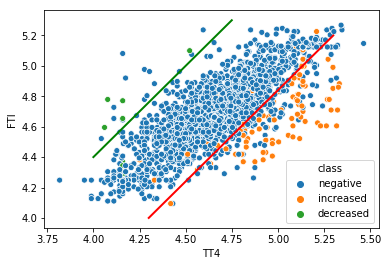

In [25]:
sns.scatterplot(x = "TT4", y = 'FTI', data = X_train, hue = 'class')
plt.plot([4.3,5.3],[4,5.2],linewidth = 2,color = 'red')
plt.plot([4,4.75],[4.4,5.3],linewidth = 2,color = 'green')

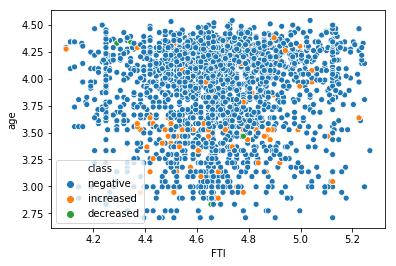

In [48]:
sns.scatterplot(x = "FTI", y = 'age', data = X_train, hue = 'class')
# plt.plot([4.3,5.3],[4,5.2],linewidth = 2,color = 'red')
# plt.plot([4,4.75],[4.4,5.3],linewidth = 2,color = 'green')

In [28]:
def manual_features(df):
    predicted = []
    for index,row in df.iterrows():
        pred = 0
         
        if row['T4U'] > 0.22 and row['TT4'] > 4.75:
            pred +=1
        
        if 1.2 * row['TT4'] - 1.16 > row['FTI']:
            pred +=1
        elif 1.2 * row['TT4'] - 0.4 < row['FTI']:
            pred -=1
        
        if pred > 1:
            predicted.append('increased')
        elif pred < 0:
            predicted.append('decreased')
        else:
            predicted.append('negative')
    
    return predicted
            
    

In [56]:
pred = manual_features(X_valid)

In [57]:
X_valid[X_valid['class'] == 'increased'].shape

(25, 48)

In [58]:
confusion_matrix(pred, X_valid['class'])

array([[  4,   0,   7],
       [  0,  19,  34],
       [  1,   6, 901]], dtype=int64)

In [59]:
accuracy_score(pred, X_valid['class'])

0.95061728395061729

## Klasifikator s vyuzitim rozhodovacich stromov